Alright onto more helio-relevant problems.  Let's consider diffusive inertial waves in a differentially rotating system with a constant density.  This system can be written as

$$
\partial_t \vec{u} + \nabla p + \hat{e}_z\times \vec{u} + \left(\nabla\times\vec{u}\right)\times\vec{v}_0 + \vec{\omega}_0\times\vec{u} - Ek \nabla^2 \vec{u} = 0,\\
\nabla\cdot\vec{u} = 0,
$$

where $Ek$ is the Ekman number defined here as $\nu/(2\Omega_0 R^2)$, with $\nu$ the kinematic viscosity, $\Omega_0$ the bulk rotation rate, and $R$ the radius of the outer bounding sphere. Likewise, $\vec{u}$ is the velocity, and $p$ a gauge field. Turning this into an eigenproblem, we assume oscillatory modes such that $\vec{u} = \overline{u} e^{-i\omega t}$, more generally there can be non-normal behavior such that $\vec{u} = \overline{u} g(t)$ for some hopefully bounded $g(t)$. To assess that we can use pseudospectra, but I'll save that for another time.

For now let us also consider the background velocity $\vec{v}_0$ and vorticity $\vec{\omega}_0$ in the rotating frame to be:

$$
\vec{v}_0 = \frac{1}{40} r z \sin(\theta) \left(1-z^{13}\right) \left(1 - \alpha \mu^2 - \beta \mu^4\right) \hat{\varphi},\\
\vec{\omega}_0 = \nabla\times{\vec{v}_0}
$$

which is a cute fit to the Solar differential rotation, where $z=\frac{r-r_i}{r_o-r_i}$ and $\mu = \cos(\theta)$.

In [1]:
#Let's get ourselves started with a few module imports.
import os
import numpy as np
import dedalus.public as d3
import matplotlib.pyplot as plt
from dedalus.core import evaluator #currently necessary, will be obsolete soon.

2023-03-01 02:44:32,573 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.
2023-03-01 02:44:32,574 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".
2023-03-01 02:44:32,733 numexpr.utils 0/1 INFO :: NumExpr defaulting to 8 threads.


In [2]:
#Datatype
dtype = np.complex128

#Problem Parameters
nphi=1 #We are going to look at axisymmetric waves here.
ntheta=128 #Number of grid points in latitude (Legendre weights)
nr=32 #Number of grid points in radius (Chebyshev weights)

ri = 0.70    #Inner radius
ro = 1.00    #Outer radius
Ek = 1e-4    #Ekman number

# Set up output directory for eigenmodes
label='0'
data_dir = 'Inertial_Waves_Ek{:.2f}'.format(np.log10(Ek))+'_'+label

#Define radii for coordinate system creators
radii = (ri,ro)

In [3]:
#For eigenproblems there's no MPI mesh for dedalus, but there can be for SLEPc.
mesh = None
# Bases
coords = d3.SphericalCoordinates('phi', 'theta', 'r') #Define the spherical coordinate names
dist = d3.Distributor(coords, mesh=mesh, dtype=dtype) #Set up the internal communicators and initialize.
#Define a shell basis (so Tensor spherical harmonics and a Chebyshev radial basis)
shell = d3.ShellBasis(coords, shape=(nphi,ntheta,nr), radii=radii, dtype=dtype)
sphere = shell.outer_surface #Define the bounding sphere coordinate systems (e.g. S_2)
phi, theta, r = dist.local_grids(shell) #Get local coordinate arrays

In [4]:
# Fields over the shell
u = dist.VectorField(coords, bases=shell, name='u') #Vector velocity field
v0 = dist.VectorField(coords, bases=shell.meridional_basis, name='v0') #Background velocity
w0 = dist.VectorField(coords, bases=shell.meridional_basis, name='w0') #Background vorticity
p = dist.Field(bases=shell, name='p') #Gauge field.

#Vertical unit vector in spherical coordinates
#This guy is special: it is defined over a meridional basis 
# (e.g. coupled in radius and theta, but not in phi).
#This restricted basis is called the meridional_basis.
ez = dist.VectorField(coords, bases=shell.meridional_basis, name='ez')

# Eigenvalue
omega = dist.Field(name='omega')

In [5]:
#Tau boundary mullifiers (dummy variables permitting the
# our spectral representation of boundary conditions)
tau_u_ri = dist.VectorField(coords, bases=sphere, name='tau_u_ri')
tau_u_ro = dist.VectorField(coords,bases=sphere, name='tau_u_ro')
tau_p = dist.Field(name='tau_p')

In [6]:
#Substitutions

dt = lambda A: -1j*omega*A #Our eigenvalue operator.

#Here we lift the taus onto the shell derivative basis 
#(So ChebyU in radius and the shifted Jacobi polynomials in latitude)
lift_basis = shell.derivative_basis(1) # First derivative basis
lift = lambda A: d3.Lift(A, lift_basis, -1)

In [7]:
#First order formulation
rvec = dist.VectorField(coords, bases=shell.meridional_basis, name='rvec')
#Radial component, since chebyshev in radius
rvec['g'][2] = r
#Define the gradient tensor and the first lift for the lower boundary
grad_u = d3.grad(u) + rvec*lift(tau_u_ri)

#For stress-free boundary conditions
strain_rate = d3.grad(u) + d3.transpose(d3.grad(u))

#Vertical unit vector
ez = dist.VectorField(coords, bases=shell.meridional_basis, name='ez')
#Theta component
ez['g'][1] = -np.sin(theta)
#Radial component
ez['g'][2] = np.cos(theta)

#Azimuthal velocity vector and associated meridional vorticity in the rotating frame
#Radial fit (15 nccs)
z = (r-ri)/(ro-ri)
fz = 0.05*z-0.05*z**14 #Radial function
fzp = (0.05 - 14e0*0.05*z**13)/(ro-ri) #And its derivative

#Latitudinal fit (5 nccs)
mu = np.cos(theta)
gt = 1-0.145*mu**2-0.148*mu**4 #Typical surface latitudinal differential rotation
gtp = 2e0*np.sin(theta)*(0.145*mu + 2e0*0.148*mu**3) #And its derivative

#Azimuthal velocity
v0['g'][0] = 0.5*r*np.sin(theta)*fz*gt

#Associated meridional vorticity
w0['g'][1] = -0.5*np.sin(theta)*gt*(r*fzp + 2e0*fz)
w0['g'][2] = 0.5*fz*(2e0*mu*gt+np.sin(theta)*gtp)

In [8]:
# Problem
problem = d3.EVP([p, u, tau_u_ri, tau_u_ro, tau_p], eigenvalue=omega, namespace=locals())

#Equations of motion
#Continuity + a tau to control the gauge field.
problem.add_equation("trace(grad_u) + tau_p = 0")
#Momentum equation with the Coriolis force.
problem.add_equation("dt(u) + grad(p) + cross(ez,u) + cross(curl(u),v0) + cross(w0,u) - Ek*div(grad_u) + lift(tau_u_ro) = 0")

{'LHS': Add(Add(Convert(Add(Add(Add(Add(Convert(Mul(Mul((-0-1j), <Field 140039289389712>), <Field 140041312735056>)), Grad(<Field 140039289389904>)), Convert(Cross(<Field 140039289638864>, <Field 140041312735056>))), Cross(Curl(<Field 140041312735056>), <Field 140039289390288>)), Convert(Cross(<Field 140039289390480>, <Field 140041312735056>)))), Mul(-1, Mul(0.0001, Div(Add(Grad(<Field 140041312735056>), Mul(<Field 140039289269840>, Lift(<Field 140041312297232>))))))), Convert(Lift(<Field 140039289395280>))),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (<dedalus.core.coords.SphericalCoordinates at 0x7f5d70352750>,),
 'dtype': dtype('complex128'),
 'M': Convert(Mul((-0-1j), <Field 140041312735056>)),
 'L': Add(Add(Convert(Add(Add(Add(Grad(<Field 140039289389904>), Convert(Cross(<Field 140039289638864>, <Field 140041312735056>))), Cross(Curl(<Field 140041312735056>), <Field 140039289390288>)), Convert(Cross(<Field 140039289390480>, <Field 140041312735056>)))), Mul(-1, Mul(0.0001, Div(

In [9]:
# Pressure Gauge
problem.add_equation("integ(p) = 0")

#Boundary conditions
stress_free=False
if (stress_free):
    problem.add_equation("radial(u(r=ri)) = 0") #Impenetrable lower boundary
    problem.add_equation("angular(radial(strain_rate(r=ri),0),0) = 0") #Stress-free lower boundary
    problem.add_equation("radial(u(r=ro)) = 0") #Impenetrable upper boundary
    problem.add_equation("angular(radial(strain_rate(r=ro),0),0) = 0") #Stress-free upper boundary
else:
    problem.add_equation("u(r=ri)=0") #No-slip boundaries
    problem.add_equation("u(r=ro)=0")

In [10]:
solver = problem.build_solver()
ss = solver.subproblems[0].subsystems[0]

#Let's use the sparse solver (waaaaay faster).
dense=False

#Let's ask for 128 eigenvalues
neig = 128

#Let's set a target for low frequency modes
guess = 0e0

if (dense):
    solver.solve_dense(solver.subproblems[0])
else:
    solver.solve_sparse(solver.subproblems[0], neig, guess)


2023-03-01 02:45:21,687 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 48s, Remaining: 0s, Rate: 2.1e-02/s


In [11]:
namespace = {}
solver.evaluator = evaluator.Evaluator(solver.dist, namespace)

if not os.path.exists('{:s}'.format(data_dir)):
    os.mkdir('{:s}'.format(data_dir))

np.save(data_dir+'/eigenvalues.npy',solver.eigenvalues)
path = data_dir + '/checkpoints'
checkpoint = solver.evaluator.add_file_handler(path, max_writes=1)
checkpoint.add_tasks(solver.state)

for i in range(neig):
    solver.set_state(i, ss)
    solver.evaluator.evaluate_handlers([checkpoint],sim_time=1,wall_time=1,timestep=1,iteration=1)

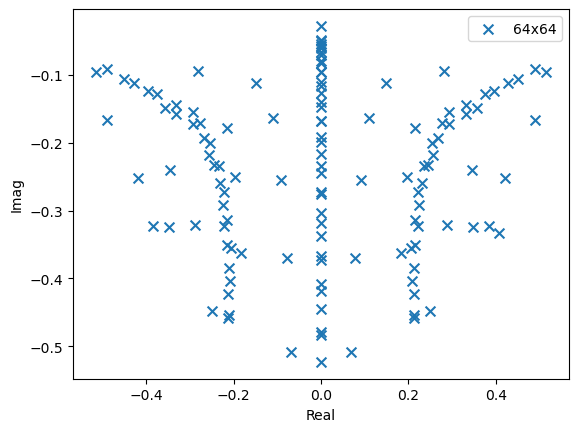

In [12]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

exists  = os.path.isdir(data_dir)
if (exists):
    eigs = np.load(data_dir+'/eigenvalues.npy')
    ax.scatter(eigs.real,eigs.imag,label='64x64',marker='x',alpha=1,s=50)

ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.legend()
fig.savefig('Eigs_compare_diff_0.png', dpi=600)